In [30]:
import os
import io
import sys

# import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import feature
from skimage import filters
from skimage import morphology
from skimage import measure

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

sys.path.append('../')
import util
import dataloader

%load_ext autoreload

In [3]:
DATA_DIR = '/Volumes/easystore/kaggle'
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_RESIZE_DIR = os.path.join(DATA_DIR, 'train_resize')
TEST_RESIZE_DIR = os.path.join(DATA_DIR, 'test_resize')

In [3]:
def get_n_samples(DIR):
    n_samples = 0
    for i in os.listdir(DIR):
        if i == '.DS_Store':
            continue
        for j in os.listdir(os.path.join(DIR, i)):
            if j == '_labels.csv':
                continue
            for k in os.listdir(os.path.join(DIR, i, j)):
                n_samples += len(os.listdir(os.path.join(DIR, i, j, k)))
    return n_samples

In [4]:
n_train_samples = get_n_samples(TRAIN_DIR)
n_test_samples = get_n_samples(TEST_DIR)

'{} training samples, {} test samples'.format(n_train_samples, n_test_samples)

NotADirectoryError: [Errno 20] Not a directory: '/Volumes/easystore/kaggle/train/_labels.csv'

In [4]:
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))
test_labels = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
train_labels.head()

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...


In [4]:
test_labels.head()

,image_id,InChI
0,00000d2a601c,InChI=1S/H2O/h1H2
1,00001f7fc849,InChI=1S/H2O/h1H2
2,000037687605,InChI=1S/H2O/h1H2
3,00004b6d55b6,InChI=1S/H2O/h1H2
4,00004df0fe53,InChI=1S/H2O/h1H2


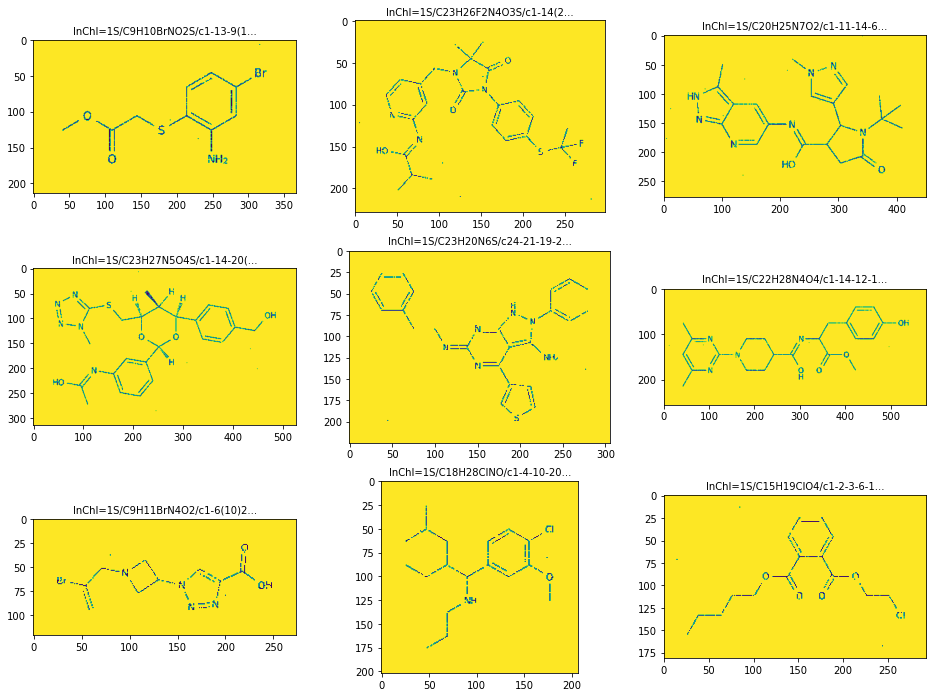

In [5]:
def get_path_from_img_id(img_id, load_dir='train'):
    if load_dir == 'train':
        DIR = TRAIN_DIR
    elif load_dir == 'test':
        DIR = TEST_DIR
    elif load_dir == 'train_resize':
        DIR = TRAIN_RESIZE_DIR
    elif load_dir == 'test_resize':
        DIR = TEST_RESIZE_DIR
    img_path = os.path.join(DIR, img_id[0], img_id[1], img_id[2], '{}.png'.format(img_id))
    return img_path

def visualize_sample(train_labels):
    plt.figure(figsize=(16,12))
    sample = train_labels.sample(n=9)
    img_ids = sample.image_id.values
    labels = sample.InChI.values
    for idx, (img_id, label) in enumerate(zip(img_ids, labels)):
        plt.subplot(3, 3, idx+1)
        img_path = get_path_from_img_id(img_id, load_dir='train')
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"{label[:30]}...", fontsize=10)
#         plt.title("{} height, {} width".format(img.shape[0], img.shape[1]))
    plt.show()

def visualize_img_id(img_id):
    plt.figure(figsize=(16,12))
    img_path = get_path_from_img_id(img_id, load_dir='train')
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.show()

visualize_sample(train_labels)

## Denoising

In [5]:
# def invert_and_normalize_img(img):
#     new_im = (255 - img) / 255
#     return new_im


# def binarize(img):
# #     thresh = filters.threshold_yen(img)
#     thresh = 0.3
#     threshed = img > thresh
#     binary = np.where(threshed == True, 1, 0)
#     return binary


# def dilate(img):
#     dilated = morphology.dilation(img, selem = morphology.octagon(1, 1))
#     return dilated


# def erode(img):
#     eroded = morphology.erosion(img, selem = morphology.octagon(1, 1))
#     return eroded


# def edge_enhance(img):
#     sharpened = filters.unsharp_mask(img, radius = 4, amount = 3)
#     return sharpened


# def edge_detect(img):
# #     edges = feature.canny(img)
#     edges = filters.sobel(img)
#     return edges


# def get_window(x, y, vertex_map, window_size = 5):
#     n_rows = (window_size * 2) + 1
#     for i in range(n_rows):
#         if i <= window_size-1:
#             row = y - (window_size - i)
#             vertex_map[(x-window_size):(x+window_size), row] = 1
            
#         if i == (window_size + 1):
#             row = y
#             vertex_map[(x-window_size):(x+window_size), row] = 1
            
#         if i >= (window_size + 1):
#             row = y + (i - window_size)
#             vertex_map[(x-window_size):(x+window_size), row] = 1
    
#     return vertex_map


# def get_vertices(img, window_size, window_mask = True):
    
#     coords = feature.corner_peaks(feature.corner_harris(img), min_distance=5, threshold_rel=0.02)
# #     coords_subpix = feature.corner_subpix(img, coords, window_size=13)
    
#     h, w = img.shape
#     vertex_map =np.zeros((h, w))
#     for i, coordinate in enumerate(coords):
#         x, y = coordinate
#         if window_size != 0:
#             vertex_map = get_window(x, y, vertex_map, window_size = window_size)
            
#         else:
#             vertex_map[x, y] = 1
                        
#     if window_mask:
#         vertex_windows = np.where(vertex_map == 1, img, 0)
#         return vertex_windows
        
#     else:    
#         return vertex_map


########################################
# don't transfer to utils. For Dev only 
########################################
def get_path_from_img_id(img_id, load_dir='train'):
    if load_dir == 'train':
        DIR = TRAIN_DIR
    elif load_dir == 'test':
        DIR = TEST_DIR
    elif load_dir == 'train_resize':
        DIR = TRAIN_RESIZE_DIR
    elif load_dir == 'test_resize':
        DIR = TEST_RESIZE_DIR
    img_path = os.path.join(DIR, img_id[0], img_id[1], img_id[2], '{}.png'.format(img_id))
    return img_path

def get_n_samples(train_labels, n = 5):
    samples = train_labels.sample(n=n)
    img_ids = samples.image_id.values
    labels = samples.InChI.values
    
    imgs = []
    for im_id in img_ids:
        img_path = get_path_from_img_id(im_id, load_dir = 'train')
        imgs.append(plt.imread(img_path))
    
    return imgs, img_ids, labels


from PIL import Image, ImageOps

def pillow_pad(img, desired_size, color=(255,255,255,0), resample=Image.LANCZOS, copy=False):
    if copy:
        img = img.copy()
    
    old_size = img.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img.thumbnail(new_size, resample)
    
    new_img = Image.new('RGB', (desired_size, desired_size), color=color)
    new_img.paste(img, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    return new_img

def resize_imgs(img_ids, save_dir='train', resize=256):
    imgs = []
    if type(img_ids) == list:
        for i, img_id in enumerate(img_ids):
            img_path = get_path_from_img_id(img_id, load_dir=save_dir)
            img = Image.open(img_path)
            img = pillow_pad(img, resize)
            img = img.convert('L')
            img = np.array(img)
            imgs.append(img)
            
    else:
        img_path = get_path_from_img_id(img_ids, load_dir=save_dir)
        img = Image.open(img_path)
        img = pillow_pad(img, resize)
        img = img.convert('L')
        img = np.array(img)
        imgs.append(img)

    return imgs

# def denoise(img):
#     edges = edge_enhance(img)
#     edges = edge_detect(edges)
#     binary = binarize(edges)
    
#     labels = measure.label(binary, connectivity = 2)
#     unique_counts = np.unique(labels, return_counts = True)
    
#     for label, count in zip(unique_counts[0], unique_counts[1]):
#         if count < 20:
#             img[labels == label] = 0
            
#     return img

# def skeletonize(img):
#     skeleton = morphology.skeletonize(img, method = 'lee')
#     return skeleton

# def fourier_filter(img, compression_percent = 95):
#     h, w = img.shape
    
#     def remove_small_magnitude_freqs(f_img_shift, h, w, compression_percent):
#         mags = np.abs(f_img_shift)
#         thresh = np.percentile(mags, compression_percent)
#         cond = np.abs(f_img_shift) < thresh
#         f_img_shift[cond] = 0
        
#         return f_img_shift
    
#     f_img = fft2(img)
#     f_img_shift = fftshift(f_img)
#     f_img_shift = remove_small_magnitude_freqs(f_img_shift, h, w, compression_percent)
    
#     f_img = ifftshift(f_img_shift)
#     filtered = np.real(ifft2(f_img))
        
#     return filtered

# def corner_detect(img):
#     coords = feature.corner_peaks(feature.corner_harris(img), min_distance=5, threshold_rel=0.02)
#     coords_subpix = feature.corner_subpix(img, coords, window_size=13)
#     return coords, coords_subpix



# def ridge_detection(img):
#     #hessian filter?
#     return ridges

# def denoiser(img):
    #TV norm denoiser?
    #return denoised
    

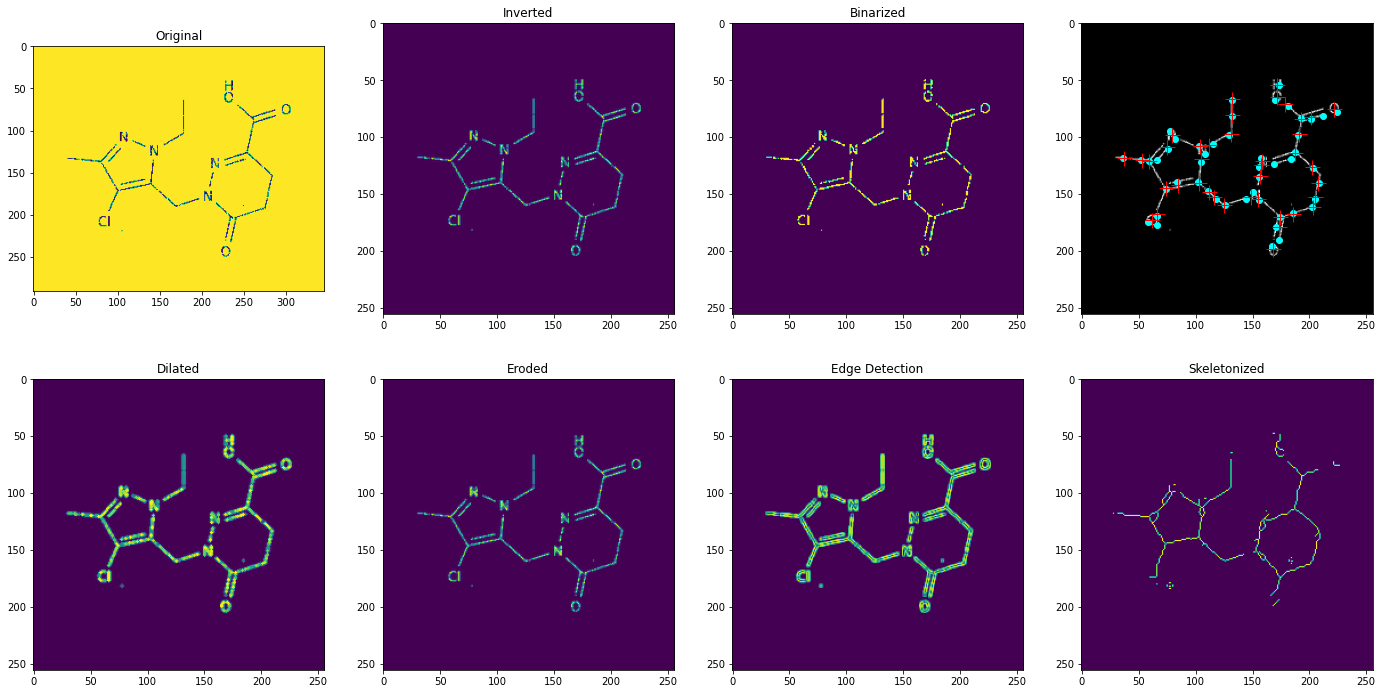

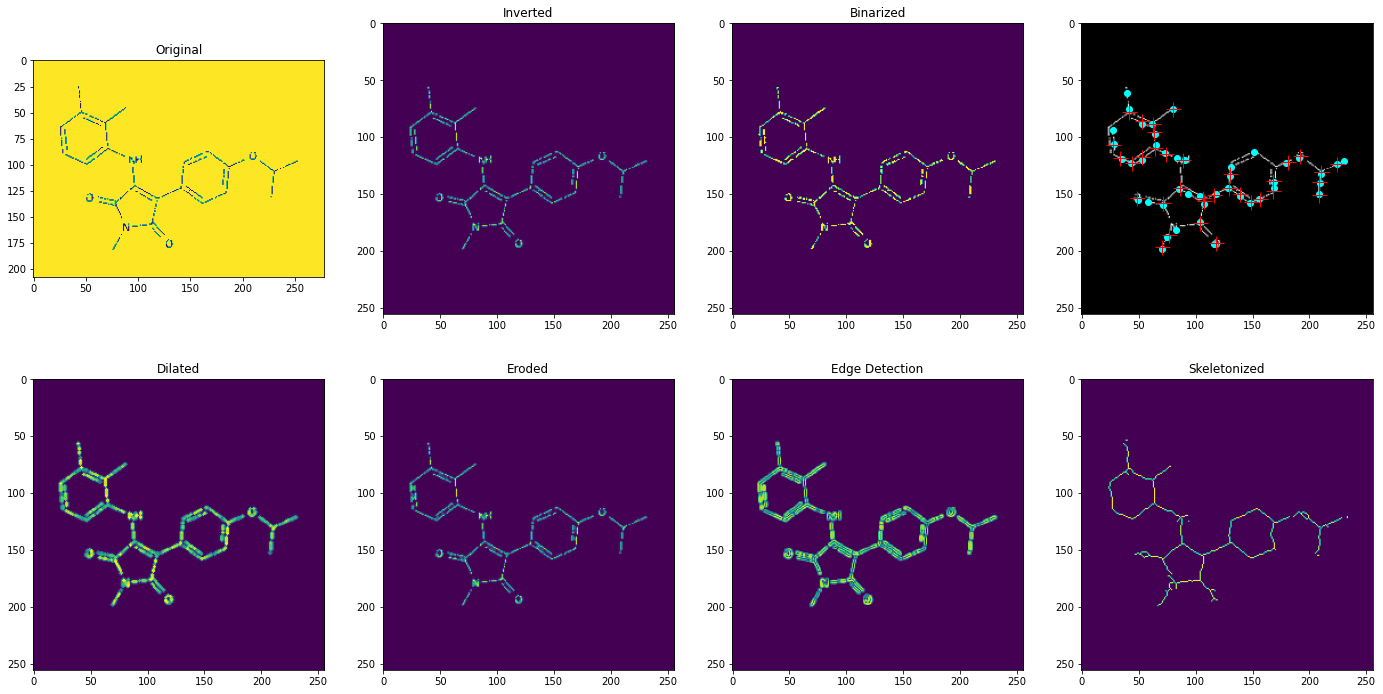

In [157]:
imgs, img_ids, labels = get_n_samples(train_labels, n = 2)

for i in range(len(img_ids)):
    fig, axs = plt.subplots(2, 4, figsize = (24, 12))
    axs = np.ravel(axs)
    
    resized = resize_imgs(img_ids[i], resize = 256)
    inverted = invert_and_normalize_img(resized[0])
    prebinarized = binarize(inverted)
    coords, coords_subpix = corner_detect(inverted)
    
    edges = edge_enhance(inverted)
    edges = edge_detect(edges)
    
    dilated = dilate(inverted)
    eroded = erode(dilated)
    skeleton = skeletonize(eroded)

    
#     filtered = fourier_filter(dilated, compression_percent = 95)
#     binarized = binarize(eroded)

    axs[0].imshow(imgs[i])
    axs[0].set_title('Original')
    
    axs[1].imshow(inverted)
    axs[1].set_title('Inverted')
    
    axs[2].imshow(prebinarized)
    axs[2].set_title('Binarized')
    
    axs[3].imshow(inverted, cmap=plt.cm.gray)
    axs[3].plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
                linestyle='None', markersize=6)
    axs[3].plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
    
    axs[4].imshow(dilated)
    axs[4].set_title('Dilated')
    
    axs[5].imshow(eroded)
    axs[5].set_title('Eroded')
    
    axs[6].imshow(edges)
    axs[6].set_title('Edge Detection')
    
#     axs[7].imshow(edges)
#     axs[7].set_title('Edge Enhancement')
    
    axs[7].imshow(skeleton)
    axs[7].set_title('Skeletonized')

plt.show()

In [84]:
def transform(img):
    """
    Takes in a 2D grayscale image and turns into multi-channel array. Each channel
    stores a different type of transformation.
    
    Currently, channels are: [img, vertices, dilated, eroded,
                              enhanced and detected edges]
    """
    
    prebinarized = util.binarize(img)
    
    edges = util.edge_enhance(prebinarized)
    edges = util.edge_detect(edges)
    
    vertices, window_list = util.get_vertices(img, window_size = 7,
                                              window_mask = True,
                                              window_list = True)
#     vertices = util.get_vertices(img, window_size = 3, window_mask = False)

#     for i, window in enumerate(window_list['windows']):
#         plt.imshow(window)
#         plt.title(window_list['coordinates'][i])
#         plt.show()
    
    closed = util.closing(prebinarized)
    
    transformed = np.dstack((img, vertices, closed, edges))
    return transformed
    
def plot_transform(transformed):
    channels = ['image', 'vertices', 'closed', 'enhanced and detected edges']
    x, y, z = transformed.shape
    
    n_rows = 2
    
    if z % 2 == 0:
        n_cols = int(z/2)
    else:
        n_cols = z//2 + 1
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize = ((6*n_cols), 12))
    axs = axs.ravel()
    
    for i in range(z):
        axs[i].imshow(transformed[:,:,i])
        axs[i].set_title(channels[i])
        
    plt.show()
    return

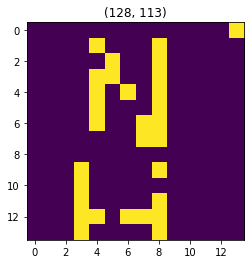

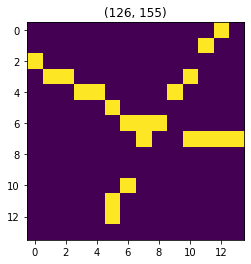

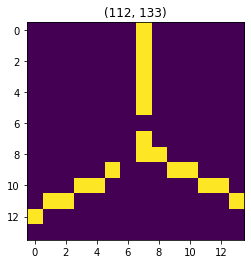

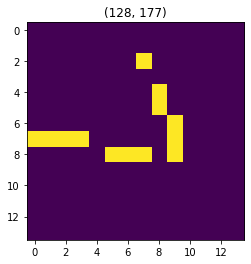

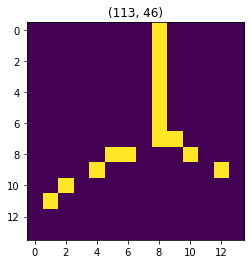

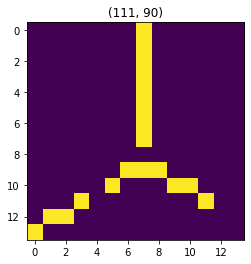

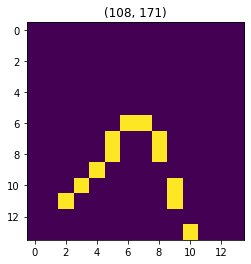

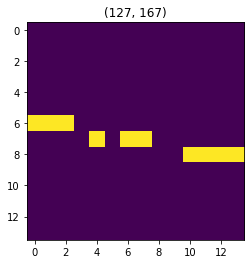

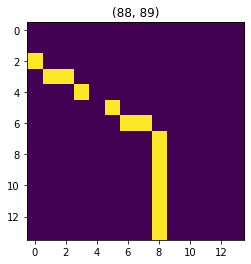

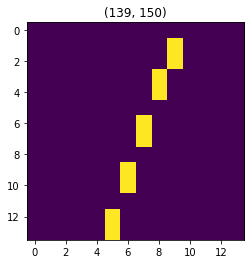

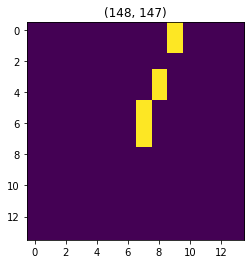

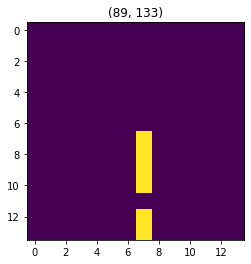

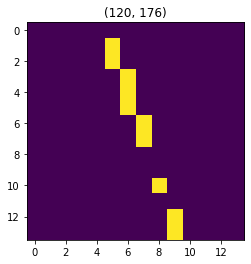

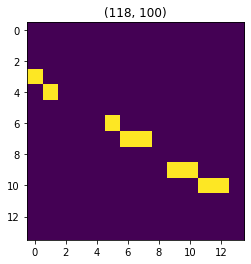

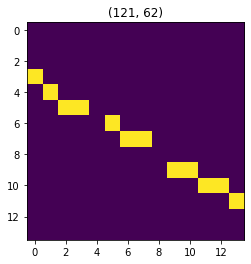

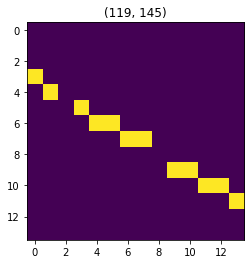

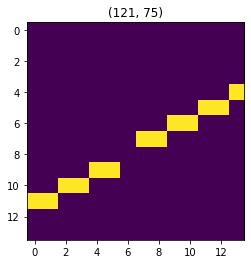

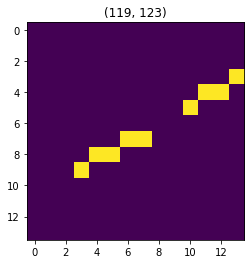

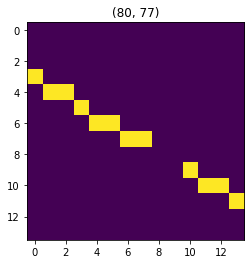

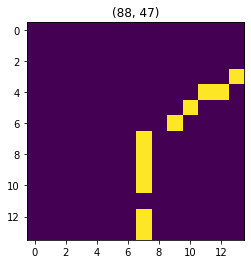

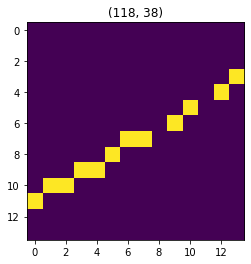

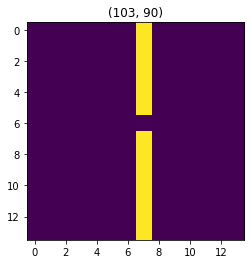

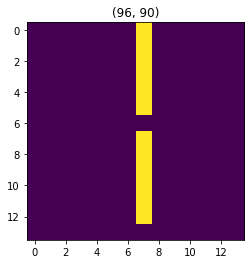

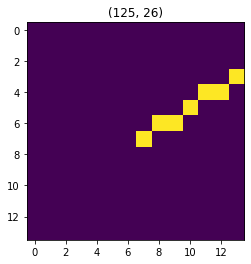

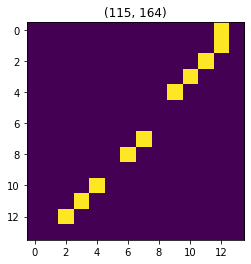

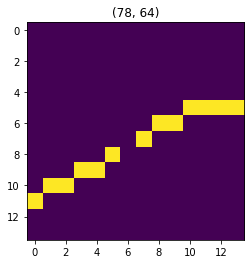

72cd82820d09


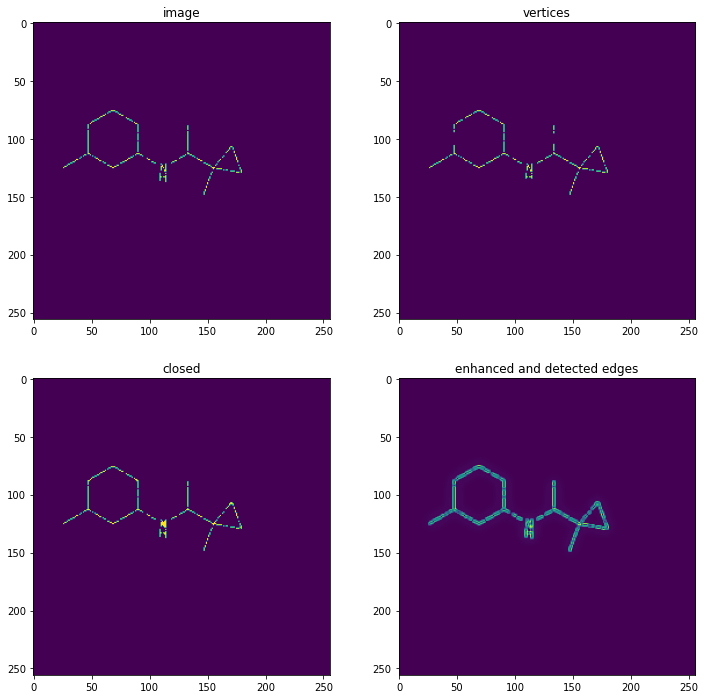

In [92]:
%autoreload
imgs, img_ids, labels = get_n_samples(train_labels, n = 1)

# img_ids = train_labels['image_id'][0]
# img_ids = 'f7d25fff4814'
    
resized = resize_imgs(img_ids[0], resize = 256)
img = util.invert_and_normalize(resized[0])
# img = resized[0]

transformed = transform(img)

print(img_ids[0])
plot_transform(transformed)

In [53]:
def denoise(img):
    edges = edge_enhance(img)
    edges = edge_detect(edges)
    binary = binarize(edges)
    
    labels = measure.label(binary, connectivity = 2)
    unique_counts = np.unique(labels, return_counts = True)
    
    for label, count in zip(unique_counts[0], unique_counts[1]):
        if count < 10:
            img[labels == label] = 0
            
    return img

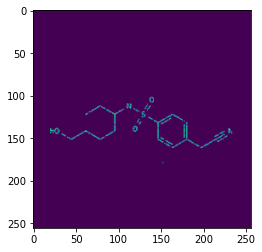

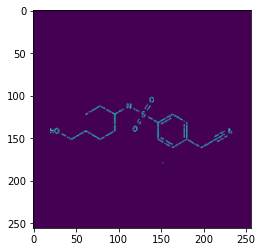

In [77]:
imgs, img_ids, labels = get_n_samples(train_labels, n = 2)
    
resized = resize_imgs(img_ids[0], resize = 256)
img = invert_and_normalize_img(resized[0])
plt.imshow(img)
plt.show()

# edges = edge_enhance(img)
# edges = edge_detect(edges)
# plt.imshow(edges)
# plt.show()

# binary = binarize(edges)

denoised = denoise(img)
# print(np.unique(denoised))
plt.imshow(denoised)
plt.show()



In [78]:
unique_counts = np.unique(denoised, return_counts = True)
unique_counts

(array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568627,
        0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
        0.03921569, 0.04313725, 0.04705882, 0.05098039, 0.05490196,
        0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.0745098 ,
        0.07843137, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
        0.09803922, 0.10196078, 0.10588235, 0.10980392, 0.11372549,
        0.11764706, 0.12156863, 0.1254902 , 0.12941176, 0.13333333,
        0.1372549 , 0.14117647, 0.14509804, 0.14901961, 0.15294118,
        0.15686275, 0.16078431, 0.16470588, 0.16862745, 0.17254902,
        0.17647059, 0.18039216, 0.18431373, 0.18823529, 0.19215686,
        0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
        0.21568627, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
        0.23529412, 0.23921569, 0.24313725, 0.24705882, 0.25490196,
        0.25882353, 0.2627451 , 0.26666667, 0.27058824, 0.2745098 ,
        0.27843137, 0.28235294, 0.28627451, 0.29

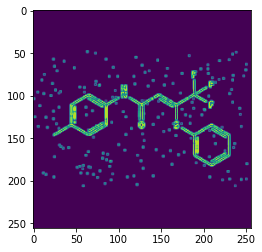

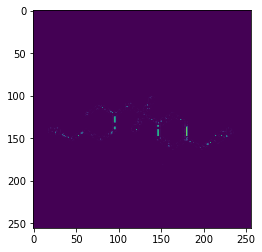

In [79]:
for label, count in zip(unique_counts[0], unique_counts[1]):
    if count < 10:
        denoised[denoised == label] = 0

plt.imshow(edges)
plt.show()
plt.imshow(denoised)
plt.show()

In [83]:
print(labels[0])

InChI=1S/C16H22N2O3S/c1-18(15-6-2-14(12-19)3-7-15)22(20,21)16-8-4-13(5-9-16)10-11-17/h4-5,8-9,14-15,19H,2-3,6-7,10,12H2,1H3


In [194]:
folder = '/Users/wesleytatum/Desktop/test/'

im_paths = os.listdir(folder)

ims = []

for path in im_paths:
#     im = plt.imread(folder+path)
#     im = im[:,:,0]
#     im.squeeze()

    im = Image.open(folder+path)
    im = im.convert('L')
    im = np.array(im)
#     im = im[:,:,0]
#     im.squeeze()
    
    ims.append(im)
    
len(ims)

16

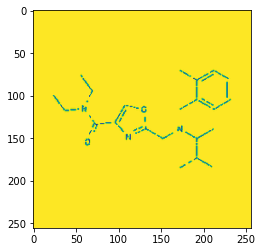

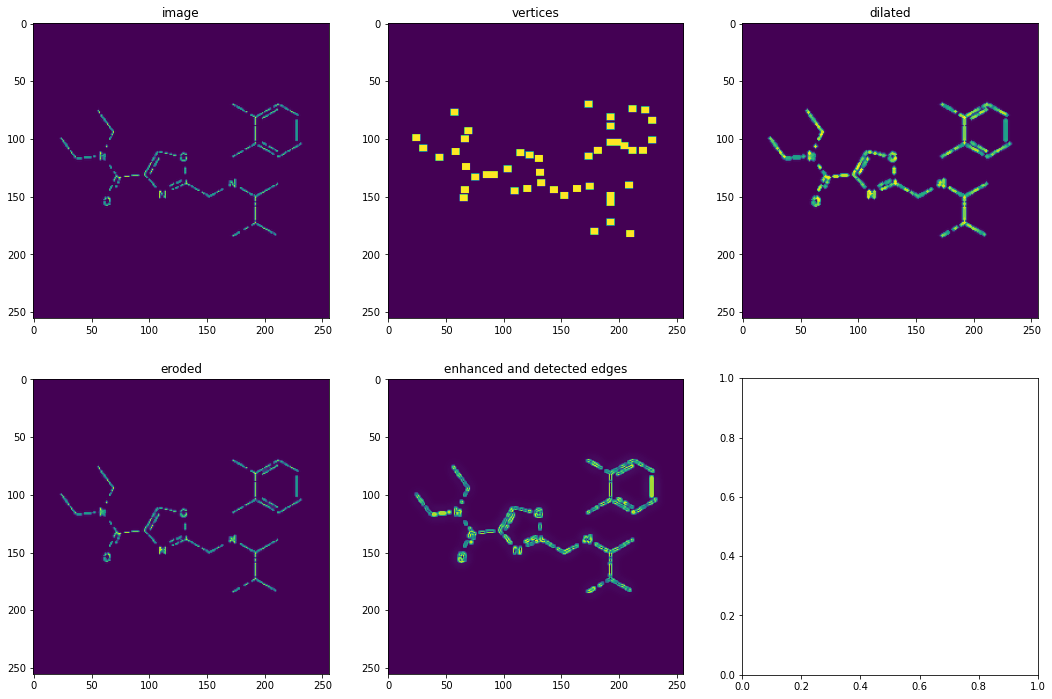

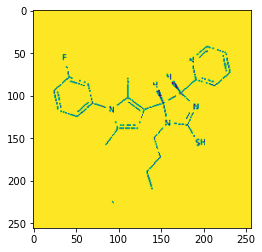

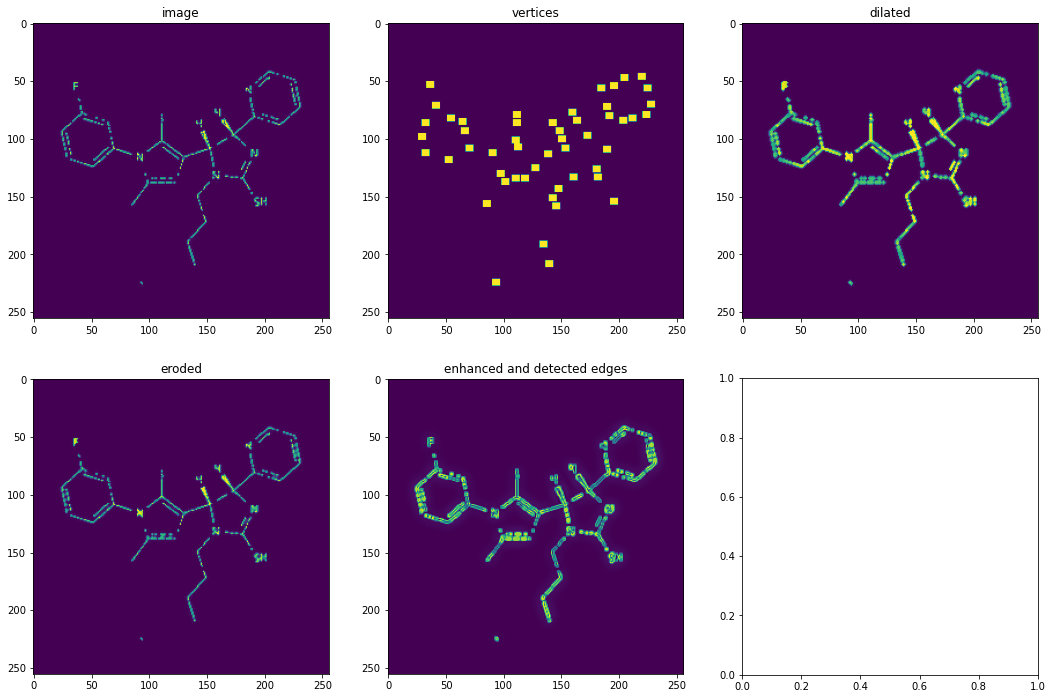

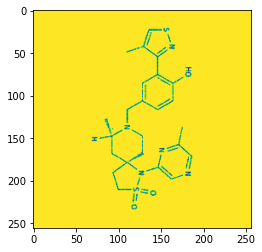

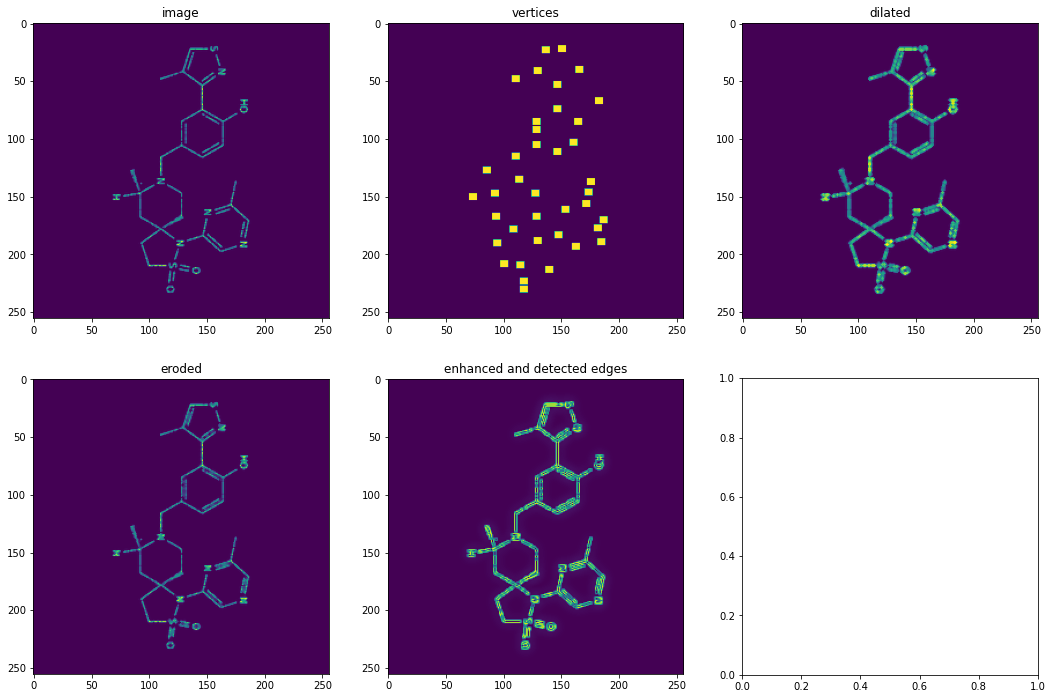

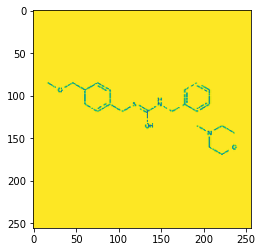

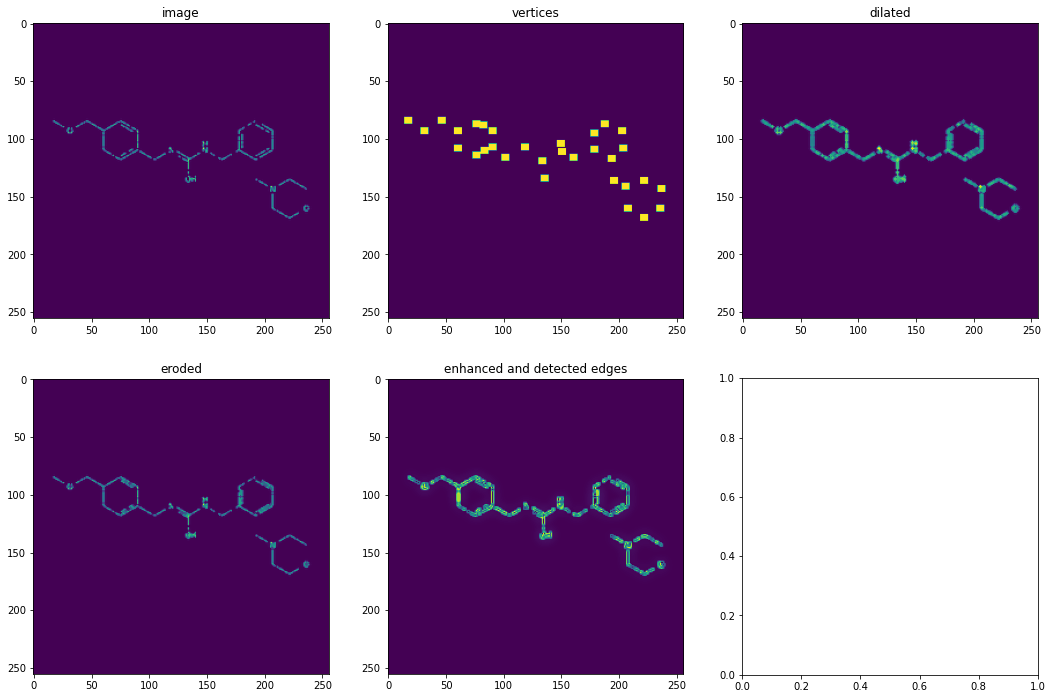

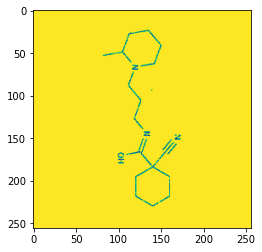

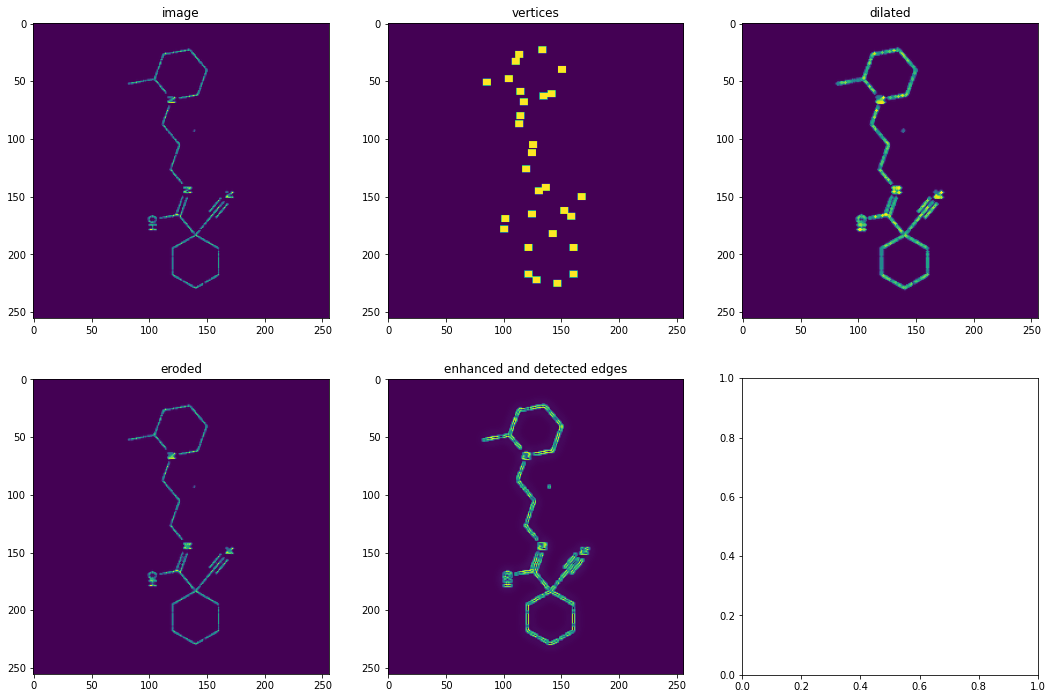

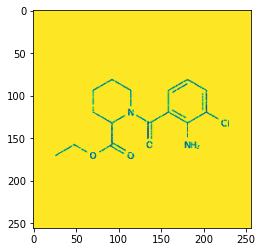

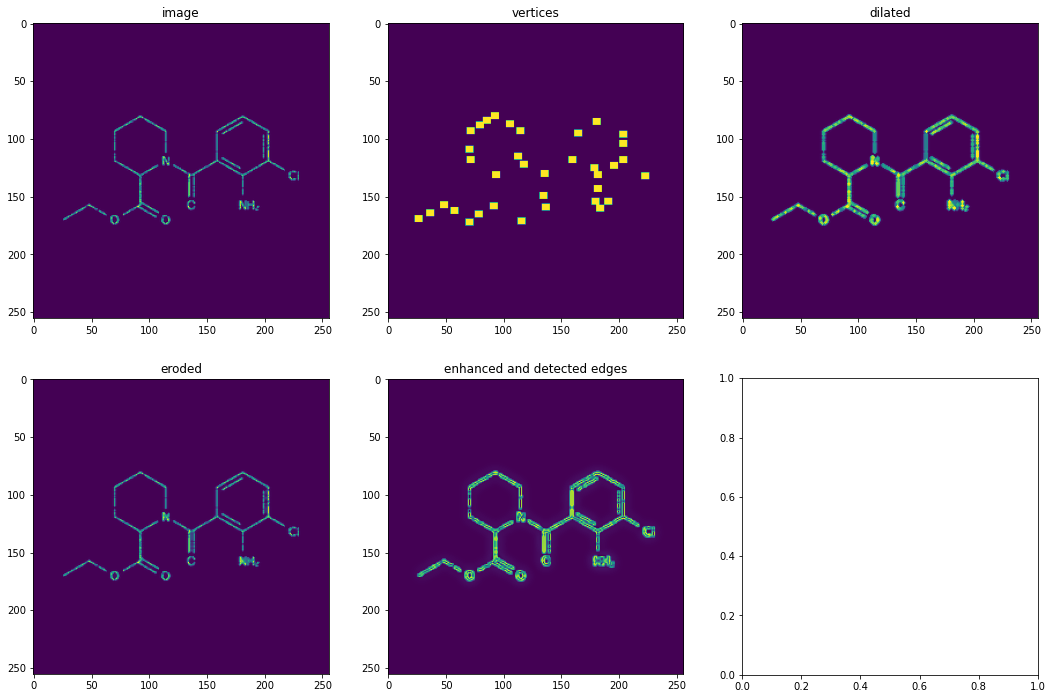

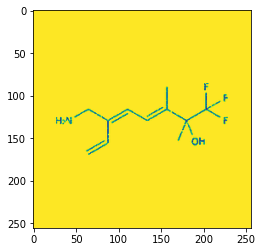

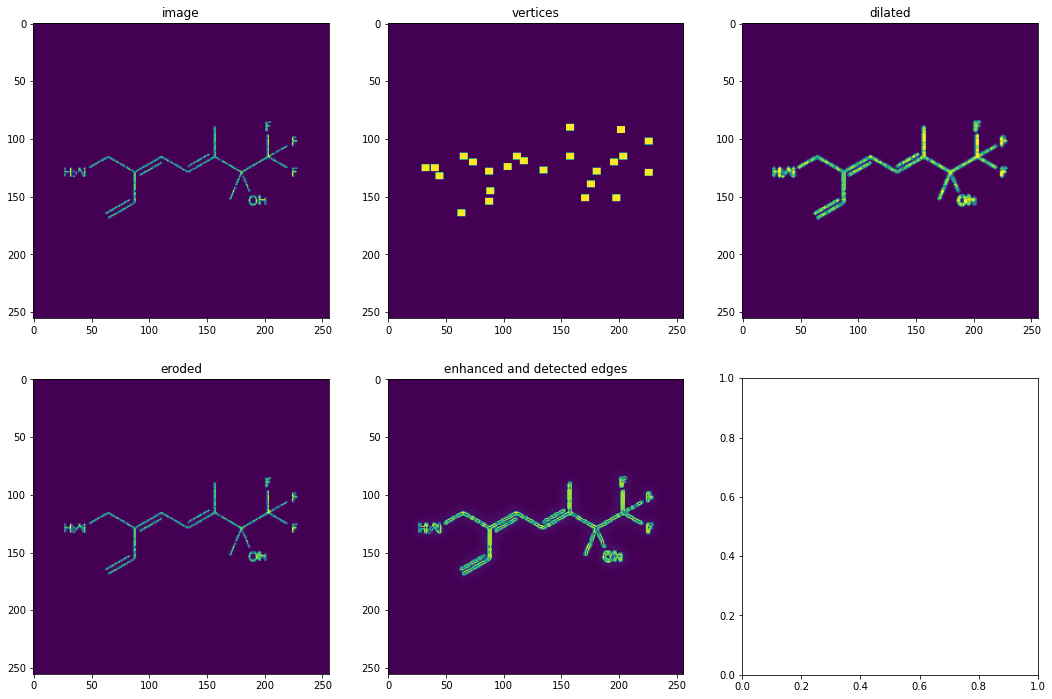

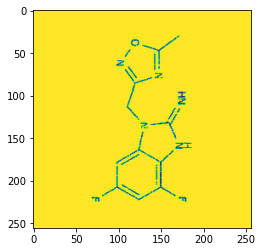

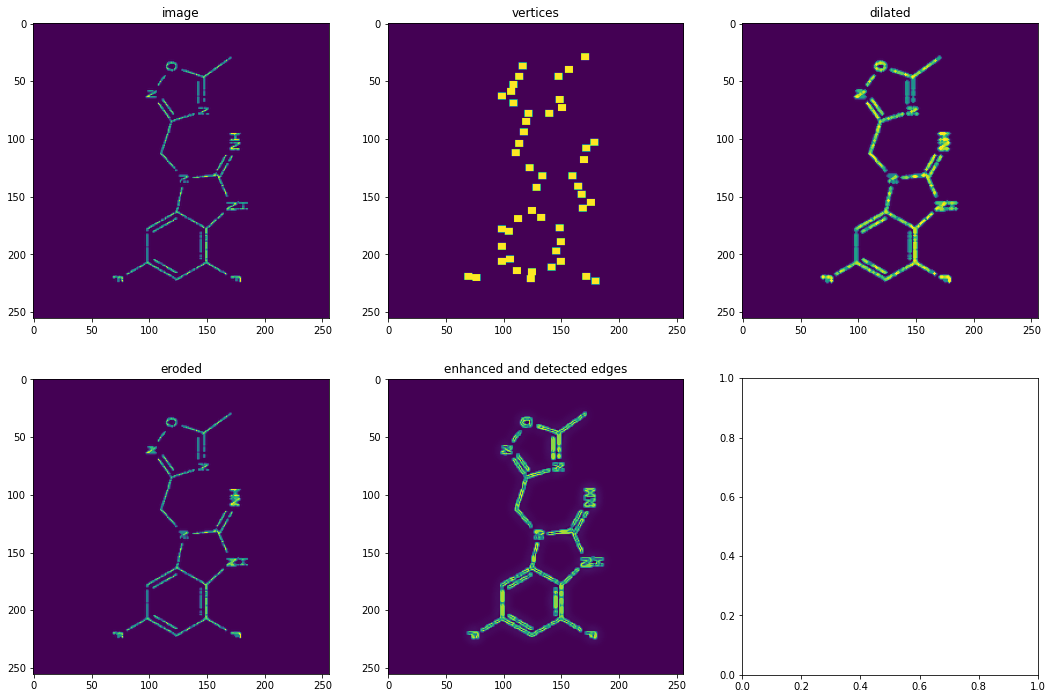

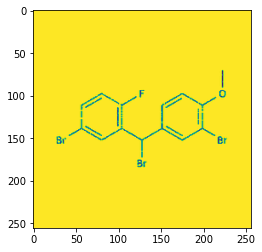

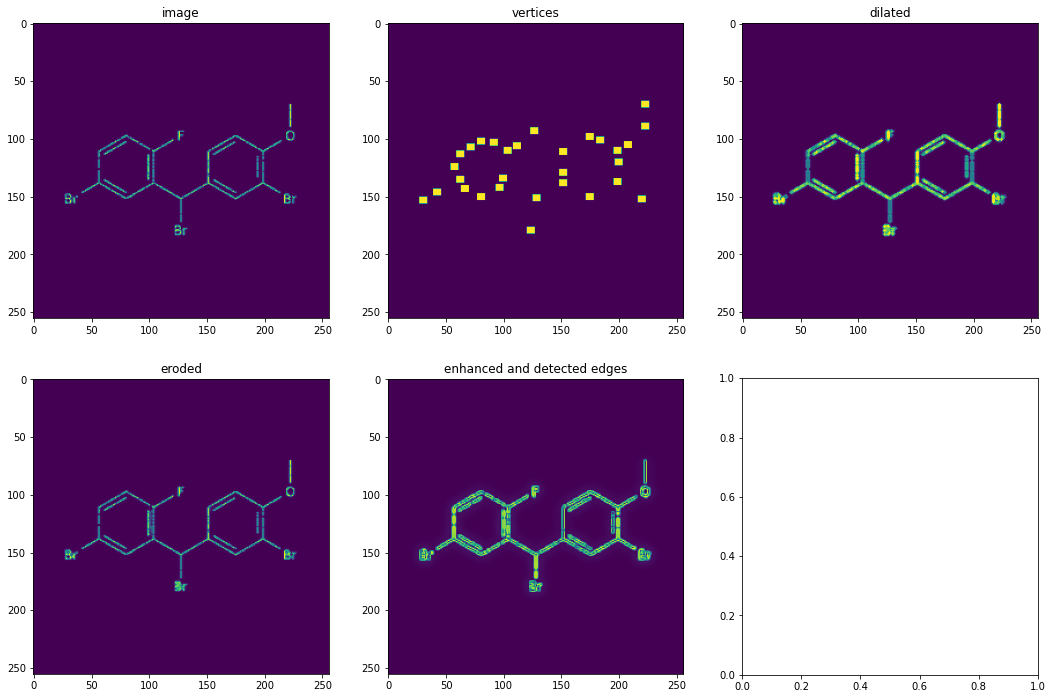

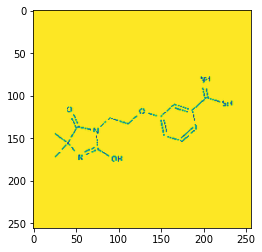

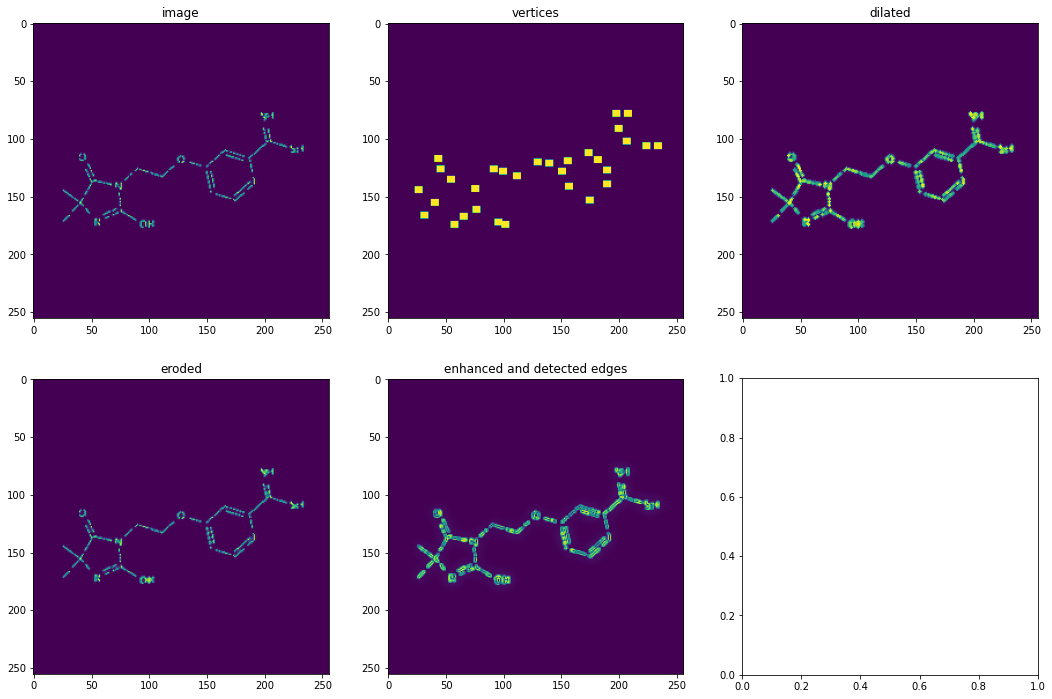

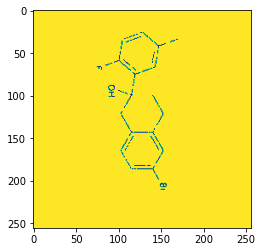

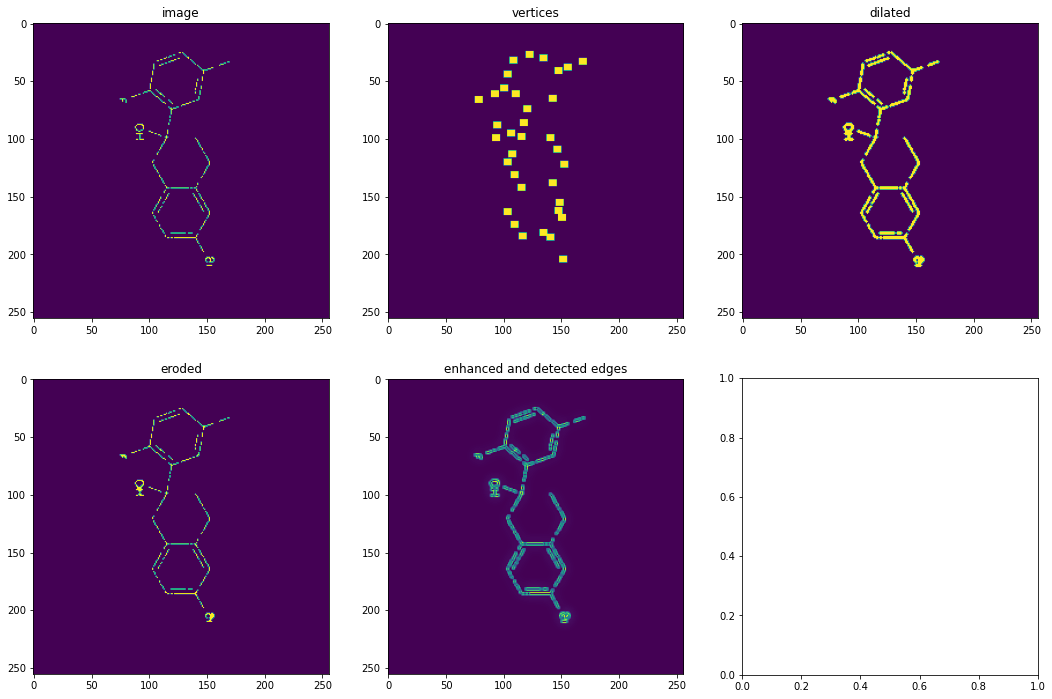

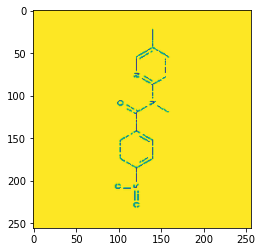

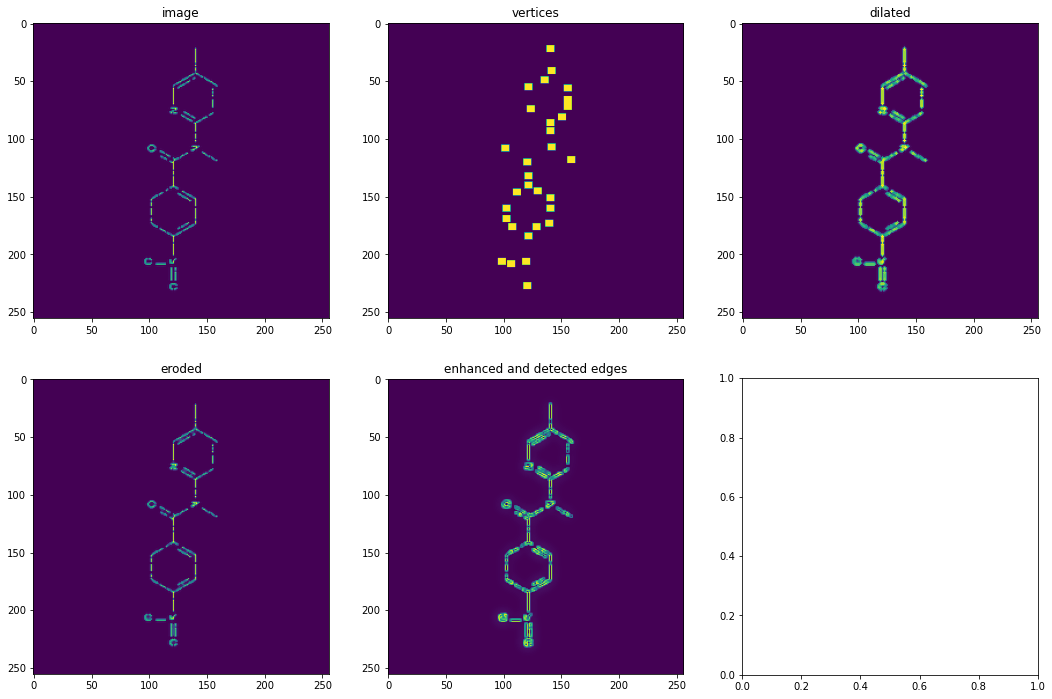

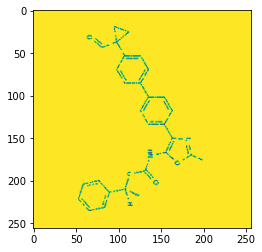

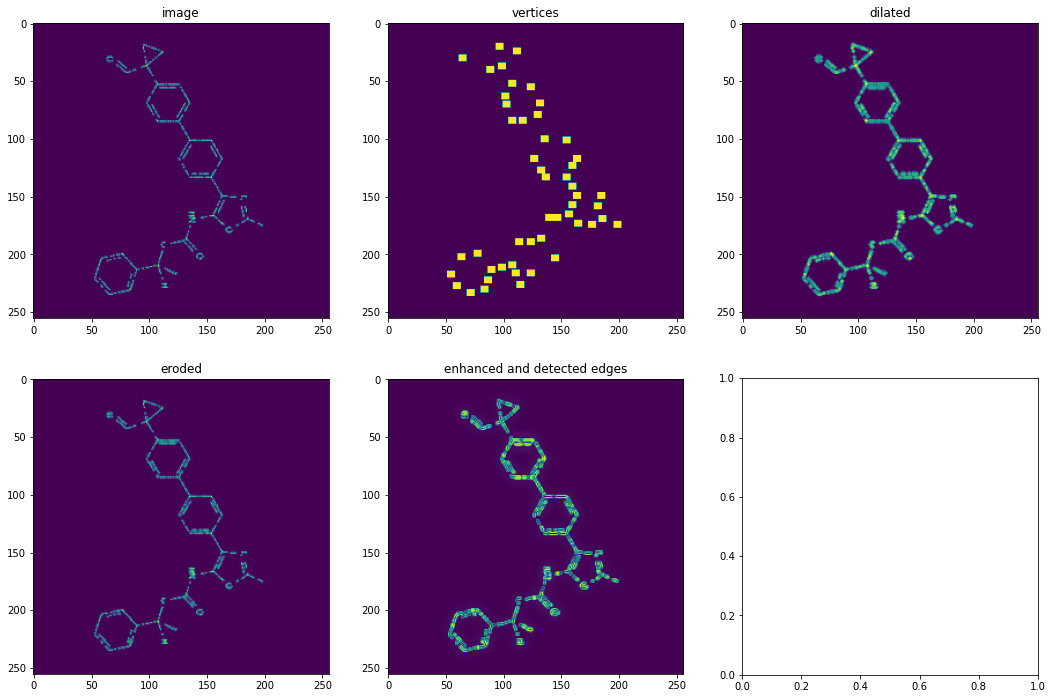

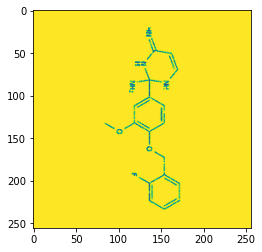

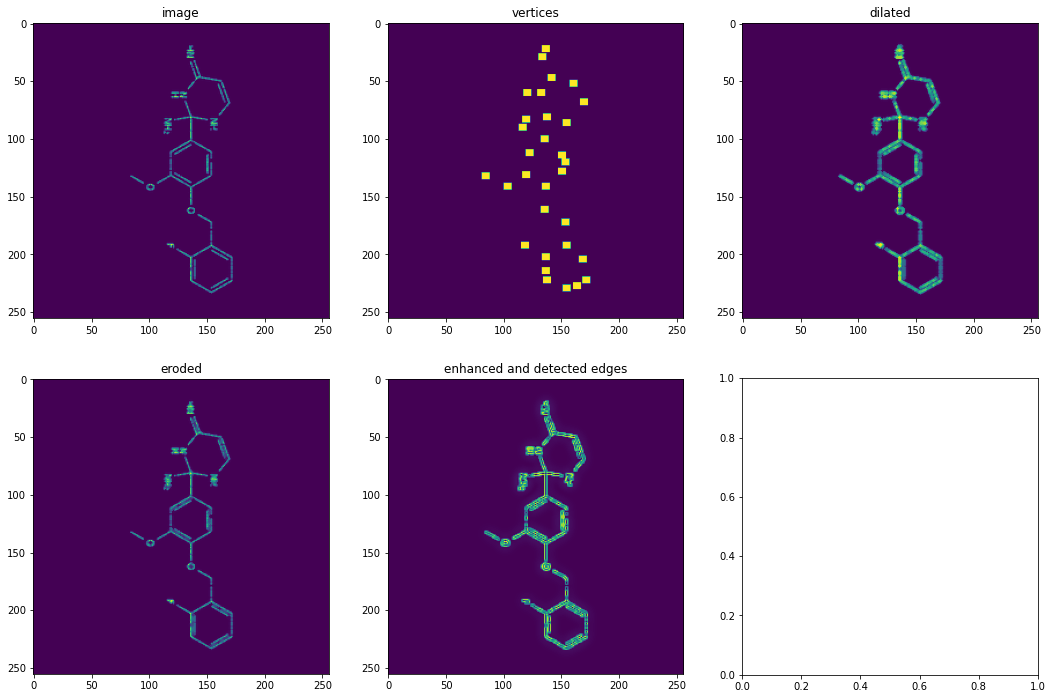

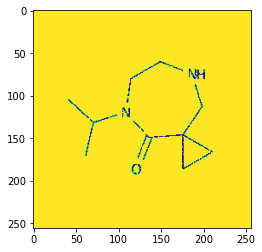

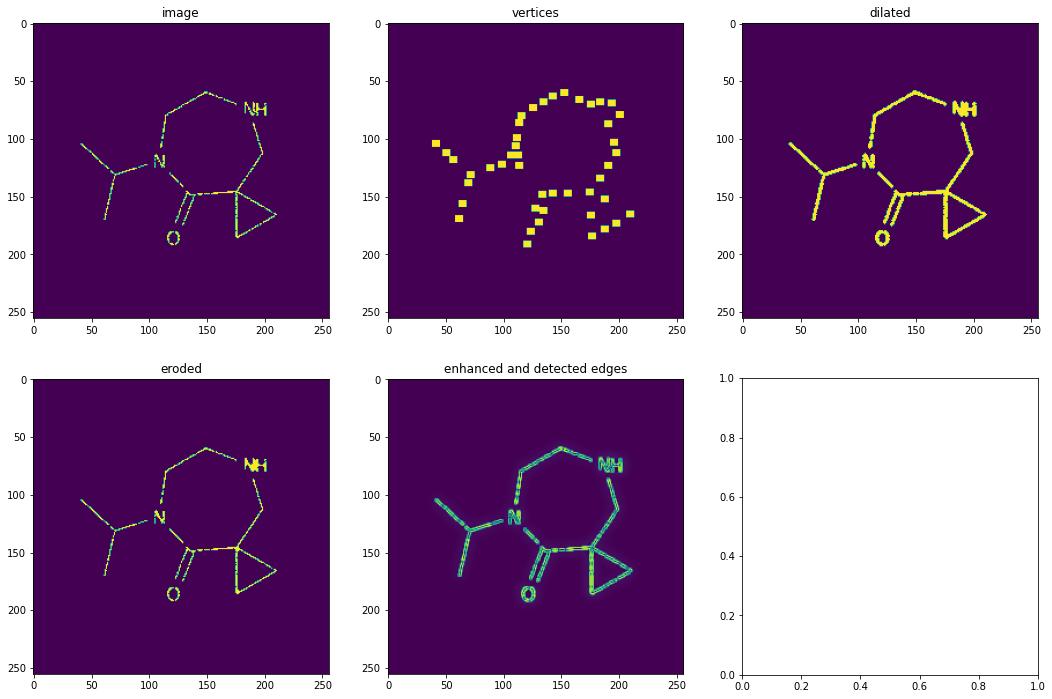

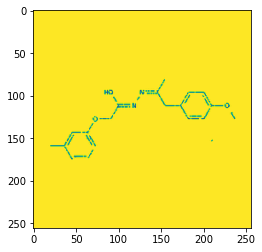

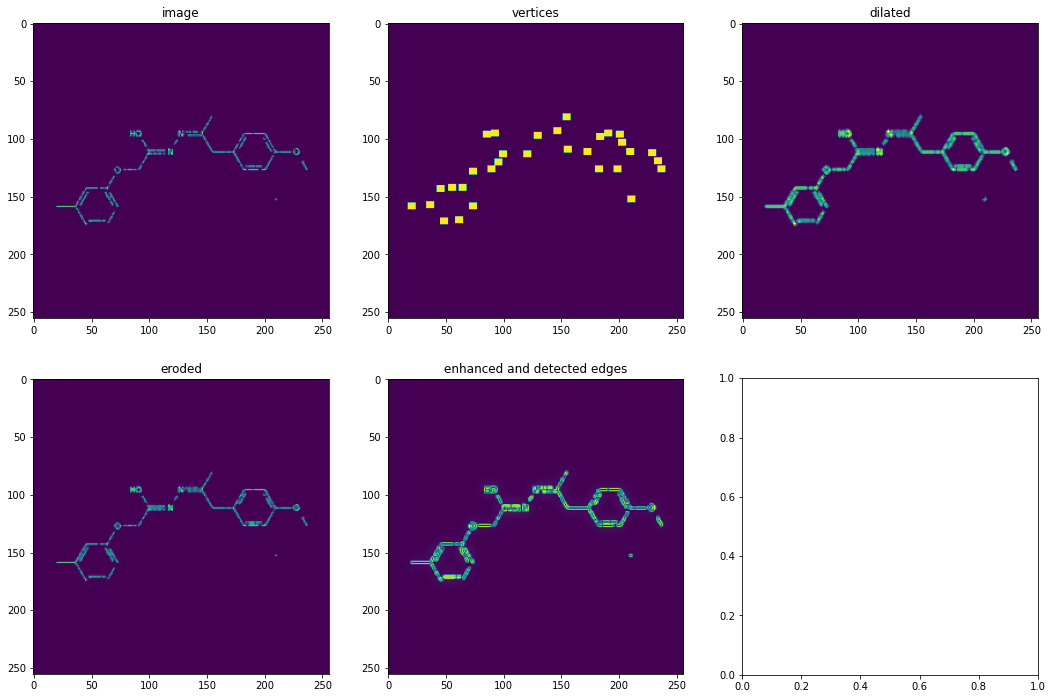

In [195]:
for im, path in zip(ims[:2], im_paths[:2]):
    plt.imshow(im)
    plt.show()
    im_id = path[:-4]
    
#     im = resize_imgs(im_id, save_dir = 'test_resize')[0]
    transformed = transform(im)
    plot_transform(transformed)

In [176]:
im_paths[2]

'000a8a3002b6.png'

[(111, 138), (132, 72), (168, 72), (131, 186), (134, 193), (106, 209), (135, 163), (115, 230), (138, 169), (119, 159), (133, 27), (114, 192), (88, 212), (128, 128), (150, 62), (148, 133), (159, 64), (144, 38), (124, 107), (108, 175), (150, 23), (113, 20), (114, 151), (137, 94)]


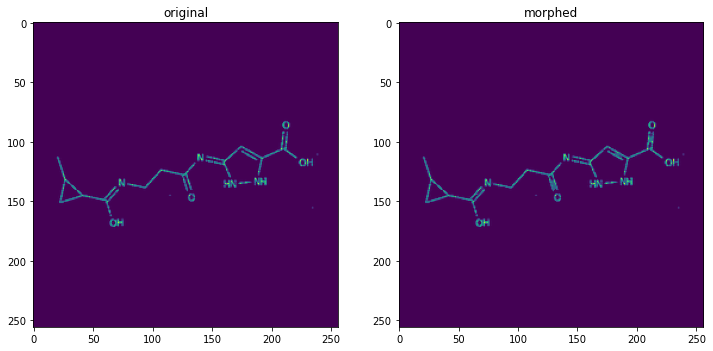

In [107]:
%autoreload
imgs, img_ids, labels = get_n_samples(train_labels, n = 1)
    
resized = resize_imgs(img_ids[0], resize = 256)
img = util.invert_and_normalize(resized[0])

vertex_windows, windows = util.get_vertices(img)
print(windows['coordinates'])

morphed = util.morph_around_windows(img, windows, util.closing)
morphed = util.morph_around_windows(img, windows, util.closing)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

ax1.imshow(img)
ax1.set_title('original')

ax2.imshow(morphed)
ax2.set_title('morphed')

plt.show()